<a href="https://colab.research.google.com/github/Adkim16/AMD_SMML_project/blob/main/AMD_SMML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Please run the project with *TPU* as runtime type!**

In [1]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
from sklearn.model_selection import GridSearchCV

tf.random.set_seed(21)  # initializing tensorflow's random seed to obtain repeatability 

from numpy.random import seed
seed(21)  # initializing numpy's random seed to obtain repeatability 

# Downloading dataset *(requires interaction)*

Uploading API Key and setting up Kaggle's folder

In [ ]:
! pip install -q kaggle
from google.colab import files

print('Upload file {kaggle.json} :\n')
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset *(should take around 5m 30s)*

In [ ]:
! kaggle datasets download --unzip -d jeffheaton/glasses-or-no-glasses

Replacing *.csv* files with my own

In [4]:
! rm test.csv
! rm train.csv
! wget -q https://raw.githubusercontent.com/Adkim16/AMD_SMML_project/main/train.csv
! wget -q https://raw.githubusercontent.com/Adkim16/AMD_SMML_project/main/test.csv

# Preprocessing dataset

Saving the name of each file in a list

In [5]:
FOLDER = "faces-spring-2020/faces-spring-2020/"

filenames = []
for image in os.scandir(FOLDER):
  filenames.append(image.name)

Extracting labels from .csv

In [6]:
train_labels = pd.read_csv('train.csv')['glasses'].to_numpy()
test_labels = pd.read_csv('test.csv')['glasses'].to_numpy()
# converting the arrays to dictionaries with {key: image's id; value: class}
train_labels = dict(enumerate(train_labels.flatten(), 1))
test_labels = dict(enumerate(test_labels.flatten(), 4501))

##Data Visualization

Visualizing some random images with their label

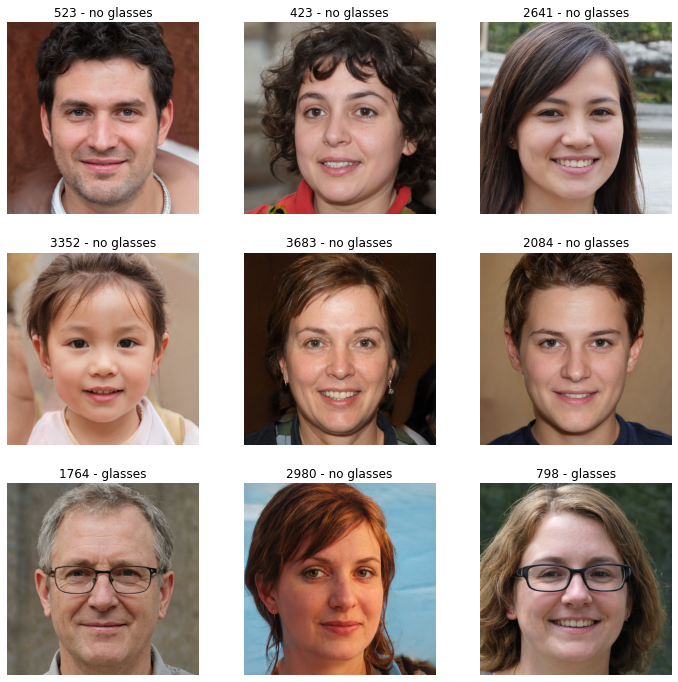

In [ ]:
rand_filenames = []  # list of random files (their path)

for i in range(9):

  # since in 'filenames' the samples are not ordered, and the test samples are those with id > 4500, I need to cycle until I find a random id <= 4500
  n = random.randint(1, len(filenames))
  while int(filenames[n][5:-4]) > 4500:
    n = random.randint(1, len(filenames))

  rand_filenames.append(FOLDER + filenames[n])  # join the folder path to the file name and add the result to the list 

plt.figure(figsize = (12, 12))

for i in range(9):

  id = int(rand_filenames[i][41:-4])  # extract id from files's name
  if train_labels[id] == 0:  # id of the images starts from 1
    label = "no glasses"
  else:
    label = "glasses"
  
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(mpimg.imread(rand_filenames[i]))
  plt.title(str(id) + " - " + label)
  plt.axis("off")

###Examples of some problems in the dataset

Incorrect labels *(id of the image)*:


* 71
* 177
* 432
* 443
* 608
* 715
* 1594
* 1810
* 2498
* 2573
* 2637
* 2726
* 2864
* 2896
* 3302
* 3394
* 4021
* 4079
* 4211
* 4218
* 4286
* 4362
* 4403
* 4436



Ambiguous images:

* 45 
* 89 
* 210 *(remove)*
* 636 
* 999 *(remove)*
* 2431 
* 2664 *(remove)*
* 3040 
* 3148  
* 3272  
* 4354 *(remove)*
* 4622 
* 4641 
* 4715 *(remove)*
* 4780 
* 4789 
* 4966 *(remove)*



Distorted images:

* 84
* 291
* 2462
* 4613
* 4693



###Data Cleansing



I created this script to **visualize the images** associated with the **test set** *(id >= 4501)*, since for those files **there was no label** and I had to **manually label them myself**.

Later I also noticed that in the **train set** there were a lot of images with the **wrong label**, so I had to check and change those too.



The script displays **9 images with incremental id**, starting from 1 *(when n=0)*.

Incrementing **n** by *1*, it will diplay the **next 9 images**.

In [ ]:
n = 0

first_id = (n*9)+1
last_id = (n*9)+10
plt.figure(figsize = (12, 12))

for i in range(9):

  id = first_id+i

  if train_labels[id] == 0:  # id of the images starts from 1
    label = "no glasses"
  else:
    label = "glasses"

  ax = plt.subplot(3, 3, i+1)
  plt.imshow(mpimg.imread(FOLDER + 'face-' + str(first_id+i) + '.png'))
  plt.title(str(first_id+i) + ' - ' + label)
  plt.axis("off")

##Data Preprocessing

###Balancing dataset



After labelling correctly all examples, let's now see **how many examples of each class** are present in the dataset.

In [ ]:
zeros = 0
ones = 0

for l in list(train_labels.keys()):
  if train_labels[l] == 0:
    zeros += 1
  elif train_labels[l] == 1:
    ones += 1
  else:
    print('error')

print('\nTrain Set:\n\tExamples of \'Glasses\': ' + str(ones) + '\n\tExamples of \'No Glasses\': ' + str(zeros))


zeros = 0
ones = 0

for l in list(test_labels.keys()):
  if test_labels[l] == 0:
    zeros += 1
  elif test_labels[l] == 1:
    ones += 1
  else:
    print('error')

print('\nTest Set:\n\tExamples of \'Glasses\': ' + str(ones) + '\n\tExamples of \'No Glasses\': ' + str(zeros))

It looks like **there are more examples of the *'Glasses'* class**, so I'll need to balance the two classes by excluding some of the examples.

Initially I'll remove those **images that I found 'ambiguous'**, meaning that they were badly generated (when creating the dataset, with a GAN), so it was difficult to determine whether the person had glasses or not and they could **deceive the classifier**. 

In [7]:
id_to_remove = [210, 999, 2664, 4354, 4715, 4966]

for id in id_to_remove:

  filenames.remove('face-'+ str(id) + '.png')

  if id >= 4501:
    test_labels.pop(id)
  else:
    train_labels.pop(id)

Once this is done, the count for the two classes is the following:


*   **Train Set**: *examples of 'Glasses': 2503 - examples of 'No Glasses': 1993*	
*   **Test Set**: *examples of 'Glasses': 297 - examples of 'No Glasses': 201*



	

Thus I'll now proceed to **remove 606 examples of the class 'Glasses'**, 510 from the *train set*, and 96 from the *test set*.

This is done by **randomly generating** some ids and adding them to a list, if they are of the class *'Glasses'*, until the target numbers are matched.

To be able to generate the same 606 random numbers every time this code is run, I initialized the seed using the following command:
```python
random.seed(11)
```

In [8]:
TARGET_TRAIN = 510
TARGET_TEST = 96

counter_train = 0
counter_test = 0

random.seed(11)  # initializing random's seed to obtain repeatability 
random_ids = []

while len(random_ids) < TARGET_TEST + TARGET_TRAIN:

    # searching for an id of the class 'Glasses'
    found = False
    while not found:
      
      # if I need train and test ids, I choose with a 50/50 probability
      if counter_train < TARGET_TRAIN and counter_test < TARGET_TEST:
        if random.randint(1,2) == 1:
          id = random.choice(list(train_labels.keys()))
        else:
          id = random.choice(list(test_labels.keys()))

      if counter_test >= TARGET_TEST and counter_train < TARGET_TRAIN:  # if I only need train ids
        id = random.choice(list(train_labels.keys()))

      if counter_train >= TARGET_TRAIN and counter_test < TARGET_TEST: # if I only need test ids
        id = random.choice(list(test_labels.keys()))
      
      if id >= 4501:  # choosing which list to check for the label
        if id not in random_ids and test_labels[id] == 1:  # checking that id is not a duplicate and its label is 'glasses'
          found = True
          random_ids.append(id)
          counter_test += 1
      else:
        if id not in random_ids and train_labels[id] == 1:
          found = True
          random_ids.append(id)
          counter_train += 1


# removing images and labels corresponding to the ids
for id in random_ids:  
  if id >= 4501:
    filenames.remove('face-'+ str(id) + '.png')
    test_labels.pop(id)
  elif id < 4501:
    filenames.remove('face-'+ str(id) + '.png')
    train_labels.pop(id)

Now the two classes are correctly balanced:


*   **Train Set**: *examples of 'Glasses': 1993 - examples of 'No Glasses': 1993*	
*   **Test Set**: *examples of 'Glasses': 201 - examples of 'No Glasses': 201*



###Reducing images' size and Normalizing pixel values

**Reducing** the size of the images from *1024x1024* to *50x50*, and **normalizing** the values to [0, 1].

Then **splitting** **images** and **labels** between *train* and *test* set.

*Should take around 3 minutes to run.*

In [9]:
IMG_SIZE = 50

train_X = []
train_y = []
test_X = []
test_y = []

for f in filenames:

  img = cv2.imread(FOLDER + f)
  reduced_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  normalized_img = reduced_img/255.0

  id = int(f[5:-4])

  if id > 4500:
    label = test_labels[id]
    test_X.append(normalized_img)
    test_y.append(label)
  else:
    label = train_labels[id]
    train_X.append(normalized_img)
    train_y.append(label)

In [10]:
train_X = np.array(train_X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
test_X = np.array(test_X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
train_y = np.array(train_y)
test_y = np.array(test_y)

# Classification

##Hyperparameter Tuning

I can now proceed to work on the classification model, I'll use a **Convolutional Neural Network** because I'm working with RGB images.

In this first phase I'll perform a **Grid Search** to find the **best configuration** for the model's **hyperparameters**.

These are the hyperparameters I chose to tune:

*   number of filters in the convolutional layer
*   size of the filters *(always squares, so a value of 3 means a 3x3 filter)*
*   size of the windows for the max pooling layer *(same as the filters)*
*   numbers of neurons in the dense layer
*   batch size
*   number of epochs

The **Grid Search** is a very long process because it has to train the model for every combination of the hyperparameters' values; this takes a bit less then *10 hours*.


In [ ]:
def create_model(n_filters, size_filters, size_maxpool, n_neurons_dense):

  cnn = Sequential()

  cnn.add(Conv2D(n_filters, (size_filters,size_filters), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(size_maxpool,size_maxpool), data_format='channels_last'))

  cnn.add(Flatten())
  cnn.add(Dense(n_neurons_dense, activation='relu'))

  cnn.add(Dense(1, activation='sigmoid'))

  cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return cnn

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn = create_model, verbose = 0)

# define the grid search parameters
hparams = dict(n_filters = [32, 64, 128],
              size_filters = [2, 3, 4],
              size_maxpool = [2, 3],
              n_neurons_dense = [64, 128],
              batch_size = [64, 128],
              epochs = [2, 3, 4])

grid = GridSearchCV(estimator = model, param_grid = hparams, scoring='accuracy', n_jobs=1)
grid_result = grid.fit(train_X, train_y)
score = grid_result.best_score_
final_parameters = grid_result.best_params_
print("Using the Grid Search, the best score is {:.2f} using {}".format(score, final_parameters))

Using the Grid Search, the best score is 0.99 using {'batch_size': 64, 'epochs': 4, 'n_filters': 64, 'n_neurons_dense': 128, 'size_filters': 3, 'size_maxpool': 2}


`Using the Grid Search, the best score is 0.99 using {'batch_size': 64, 'epochs': 4, 'n_filters': 64, 'n_neurons_dense': 128, 'size_filters': 3, 'size_maxpool': 2}`

These values **coincides** with the **best configuration I found** when testing manually, although the only parameter I'll modify is the *number of epochs*, because the function doesn't care about the test error and will always choose the models with lower training errors, thus not avoiding overfitting.

##Final Model Training and Testing

I can now proceed to the **creation** of the classification model, this is the final configuration based on the hyperparameter tuning:

* a **convolution** layer, with **64 *3x3* filters**, *followed by a **2x2** **max pooling** layer*
* a **flattening** layer which transforms the input into a 1D array
* a **dense** layer with **128 neurons**
* an **output** layer with **1 neuron** and ***sigmoid* activation function**

The output neuron will have a value between 0 and 1 that represents the model's prediction on the class of the image *(0 for 'no glasses', 1 for 'glasses')*.

Then the model is **compiled** with:

* *loss function:* binary cross entropy
* *optimizer:* Adam
* *metrics:* accuracy

Finally I can **train** the model, passing the *train examples and labels* as arguments, and choosing:

* *batch size*: 64 *(because of the cardinality of the training set)*
* *epochs*: 3 *(to enable a good accuracy, but also avoid overfitting)*





*Should take around 1m 30s to run.*

In [11]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

print('\nTraining model:\n')
model.fit(train_X, train_y, batch_size=64, epochs=3)
print('\nEvaluating model on test set: \n')
model.evaluate(test_X, test_y)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4718720   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,720,641
Trainable params: 4,720,641
Non-trainable params: 0
_________________________________________________________________

Training model:

Epoch 1/3
63/63 [==============================] - 15s 215ms/step - loss: 0.3309 - accuracy: 0

[0.06927454471588135, 0.9800994992256165]

The result is satisfying as the model reaches an **accuracy** of **98.9%** on the *train set*, and of **98.0%** on the *test set*.

To better show the performance of the model on the test set, I created the following script.



In [12]:
zeros = 0
ones = 0

for i in range(0, len(test_y)):
  prediction = model(np.array(test_X[i].reshape(-1, IMG_SIZE, IMG_SIZE, 3)))

  if prediction >= 0.5:
    prediction = 1
  else:
    prediction = 0 

  label = test_y[i]

  if label != prediction:
    if label == 0:
      zeros += 1
    else:
      ones += 1

print('Examples wrongly predicted:\n\tNo Glasses: '+ str(zeros) + '\n\tGlasses: ' + str(ones))
print('\nTotal examples: ' + str(len(test_y)))

Examples wrongly predicted:
	No Glasses: 0
	Glasses: 8

Total examples: 402


This result shows that perhaps there is more uncertainty when trying to predict the *'Glasses'* images.